In [1]:
import librosa
from strechableNumpyArray import StrechableNumpyArray
import numpy as np
import os

pathToDatasetFolder = 'commands/'
numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
dirs = [pathToDatasetFolder+number for number in numbers]
audios = StrechableNumpyArray()
i = 0
total = 0
print('start')
for directory in dirs:
    print(directory)
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):      
            audio, sr = librosa.load(directory + '/' + file_name, sr=None, dtype=np.float64)

            if len(audio) < 16000:
                before = int(np.floor((16000-len(audio))/2))
                after = int(np.ceil((16000-len(audio))/2))
                audio = np.pad(audio, (before, after), 'constant', constant_values=(0, 0))
#             if len(audio) < 16000:
#                 print(file_name, "is too short: ", len(audio))
#                 continue
            if len(audio) > 16000: 
                print(file_name, "is too long: ", len(audio))
            if np.sum(np.absolute(audio)) < len(audio)*1e-4: 
                print(file_name, "doesn't meet the minimum amplitude requirement")
                continue

            audios.append(audio[:16000])
            i+=1

            if i > 1000:
                i -= 1000
                total += 1000
                print("1000 plus!", total)
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio))).astype(np.float64)



start
commands/zero
1000 plus! 1000
1000 plus! 2000
d90b4138_nohash_2.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_0.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_1.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_2.wav doesn't meet the minimum amplitude requirement
commands/one
1000 plus! 3000
1000 plus! 4000
d197e3ae_nohash_4.wav doesn't meet the minimum amplitude requirement
dea820ce_nohash_1.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_0.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_1.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_2.wav doesn't meet the minimum amplitude requirement
commands/two
1000 plus! 5000
51055bda_nohash_4.wav doesn't meet the minimum amplitude requirement
712e4d58_nohash_3.wav doesn't meet the minimum amplitude requirement
1000 plus! 6000
d197e3ae_nohash_2.wav doesn't meet the minimum amplitude requirement
e96a5020_nohash_0.wav doesn't 

In [2]:
audios.shape

(23595, 16000)

In [7]:
from IPython.display import display, Audio

for i in range(0, audios.shape[0], audios.shape[0]//10):
    display(Audio(audios[i], rate=16000))

In [ ]:
from ourLTFATStft import LTFATStft
import ltfatpy
from modGabPhaseGrad import modgabphasegrad
ltfatpy.gabphasegrad = modgabphasegrad # This function is not implemented for one sided stfts with the phase method on ltfatpy

fft_hop_size = 128
fft_window_length = 512
L = 16384

anStftWrapper = LTFATStft()
spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
print(spectrograms.shape)
gs = {'name': 'gauss', 'M': 512}
    
for index, audio in enumerate(audios):
    realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
    spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-10, normalize=True)
    spectrograms[index] = spectrogram  
    tgradreal, fgradreal = ltfatpy.gabphasegrad('phase', np.angle(realDGT), fft_hop_size,
                                                fft_window_length)
    tgrads[index] = tgradreal /64
    fgrads[index] = fgradreal /256


In [43]:
"""Alternatively, compute the derivs with the dgt method"""

# from ourLTFATStft import LTFATStft
# import ltfatpy

# anStftWrapper = LTFATStft()
# spectrograms = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# tgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# fgrads = np.zeros([len(audios), int(fft_window_length//2+1), int(L/fft_hop_size)], dtype=np.float64)
# print(spectrograms.shape)
# gs = {'name': 'gauss', 'M': 512}
# L = 16384
    
# for index, audio in enumerate(audios):
#     realDGT = anStftWrapper.oneSidedStft(signal=audio, windowLength=fft_window_length, hopSize=fft_hop_size)
#     spectrogram = anStftWrapper.logMagFromRealDGT(realDGT, clipBelow=np.e**-10, normalize=True)
#     spectrograms[index] = spectrogram  
#     tdgtgrad, fdgtgrad, c = ltfatpy.gabphasegrad('dgt', audio, gs, 128, 512, L=L)
#     tgrads[index] = tdgtgrad[:int(fft_window_length//2+1)]
#     fgrads[index] = fdgtgrad[:int(fft_window_length//2+1)]


(23595, 257, 128)


In [33]:
"""This needs to be refactored to work with any length of dataset"""
import scipy.io
print(spectrogram.max())
print(spectrogram.min())
print(spectrogram.mean())

shiftedSpectrograms = spectrograms/5+1
print(shiftedSpectrograms.max())
print(shiftedSpectrograms.min())
print(shiftedSpectrograms.mean())
print(shiftedSpectrograms[:, :128].mean())

scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_1.mat', dict(logspecs=shiftedSpectrograms[:4000], tgrad=tgrads[:4000], fgrad=fgrads[:4000]))
scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_2.mat', dict(logspecs=shiftedSpectrograms[4000:8000], tgrad=tgrads[4000:8000], fgrad=fgrads[4000:8000]))
scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_3.mat', dict(logspecs=shiftedSpectrograms[8000:12000], tgrad=tgrads[8000:12000], fgrad=fgrads[8000:12000]))
scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_4.mat', dict(logspecs=shiftedSpectrograms[12000:16000], tgrad=tgrads[12000:16000], fgrad=fgrads[12000:16000]))
scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_5.mat', dict(logspecs=shiftedSpectrograms[16000:20000], tgrad=tgrads[16000:20000], fgrad=fgrads[16000:20000]))
scipy.io.savemat('logspectrograms_tgrad_fgrad_gauss_512_128_clipbelow_e-10_shifted_commands_6.mat', dict(logspecs=shiftedSpectrograms[20000:], tgrad=tgrads[20000:], fgrad=fgrads[20000:]))

0.0
-10.0
-6.863348289482903
1.0
-1.0
-0.5086982442073527
-0.3613701506618347


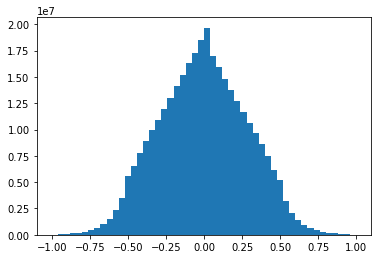

In [10]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (32, 16)

plt.hist(tgrads[:10000].flatten(), 50);

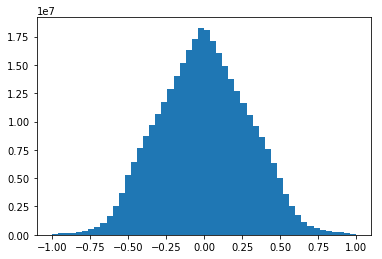

In [11]:
plt.hist(fgrads[:10000].flatten(), 50);

-0.5086982442073527
-1.0
1.0
0.0


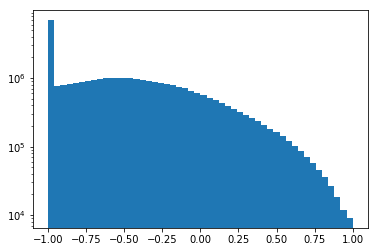

In [22]:
shiftedSpectrograms = spectrograms/5+1
print(np.mean(shiftedSpectrograms))
print(np.min(shiftedSpectrograms))
print(np.max(shiftedSpectrograms))

print(np.max(spectrogram))

plt.hist(shiftedSpectrograms[:1000].flatten(), 50);

plt.yscale('log', nonposy='clip')